# Проект: Мобильные игры   
## 1 вариант
Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:  
1.В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.  
2.Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.  
3.Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.
 


### 1 Задание  
Провожу предварительный анализ данных.
Импортирую библиотеки

In [1]:
import pandas as pd
import numpy as np
from datetime import date,timedelta
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.stats.proportion as smp
import pingouin as pg


In [2]:
reg_data = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [4]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [5]:
reg_data.duplicated().sum()

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


0

#### Вывод на основе первичного рассматрения данных: 
1) В датасете reg_data 1000000 строк и 2 столбца. Нет дубликатов и пропущенных значений  
2) Необходимо перевести дату в удобный формат

In [6]:
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s')
reg_data.head()

,reg_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,2000-01-13 22:27:27,3
3,2000-05-28 14:19:01,4
4,2000-09-16 11:21:53,5


In [7]:
reg_data.describe(include='all', datetime_is_numeric=True)

,reg_ts,uid
count,1000000,1.000000e+06
mean,2019-01-24 12:12:34.523666688,5.552354e+05
min,1998-11-18 09:43:43,1.000000e+00
25%,2018-06-03 13:55:11.500000,2.776438e+05
50%,2019-07-30 02:35:25,5.550455e+05
75%,2020-04-01 16:28:40.500000,8.329712e+05
max,2020-09-23 15:17:24,1.110622e+06
std,NaN,3.206011e+05


В данном датасете у нас данные с 1998 года по 2020 год. Данных достаточно много, для выполнения задания стоит заложить возможность ограничения при подсчете ретеншена по минимальной и максимальной дате регистрации, для более быстрого подсчета.

In [8]:
auth_data = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')

In [9]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [10]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [11]:
auth_data.duplicated().sum()

0

##### Вывод на основе первичного рассматрения данных:
1) В датасете auth_data 9601013 строк и 2 столбца. Нет дубликатов и пропущенных значений  
2) Необходимо перевести дату в удобный формат

In [12]:
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s')
auth_data.head()

,auth_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,1999-07-25 16:46:46,2
3,1999-07-31 03:50:15,2
4,1999-08-05 17:49:39,2


In [13]:
auth_data.describe(include='all', datetime_is_numeric=True)

,auth_ts,uid
count,9601013,9.601013e+06
mean,2019-01-29 16:12:06.254851584,3.347198e+05
min,1998-11-18 09:43:43,1.000000e+00
25%,2018-06-07 12:40:47,9.599700e+04
50%,2019-07-31 12:43:16,2.579210e+05
75%,2020-04-02 10:25:21,5.190250e+05
max,2020-09-23 15:17:24,1.110622e+06
std,NaN,2.832669e+05


Данные в таблице захода в игру соответсвуют данным в таблице регистрации, поэтому соединим два датасета по uid.

In [14]:
data = pd.merge(reg_data, auth_data, on = 'uid')
data

,reg_ts,uid,auth_ts
0,1998-11-18 09:43:43,1,1998-11-18 09:43:43
1,1999-07-22 22:38:09,2,1999-07-22 22:38:09
2,1999-07-22 22:38:09,2,1999-07-25 16:46:46
3,1999-07-22 22:38:09,2,1999-07-31 03:50:15
4,1999-07-22 22:38:09,2,1999-08-05 17:49:39
...,...,...,...
9601008,2020-09-23 15:13:54,1110618,2020-09-23 15:13:54
9601009,2020-09-23 15:14:46,1110619,2020-09-23 15:14:46
9601010,2020-09-23 15:15:39,1110620,2020-09-23 15:15:39
9601011,2020-09-23 15:16:31,1110621,2020-09-23 15:16:31


In [15]:
(data['auth_ts'] < data['reg_ts']).value_counts()

False    9601013
dtype: int64

Проверили есть ли некорректные данные, когда заход в игру происходит раньше регистрации.  
Таких данных нет

In [16]:
def retention(full_data, min_reg_date, max_reg_date, period_in_days):
    """
        Функция подсчета retention и показа его в виде heatmap для заданных параметров
        
        Parameters
        ----------
        full_data : DataFrame
            таблица с uid(уникальный идентификатор пользователя), reg_ts(дата регистрации), auth_ts(дата захода в игру)
        min_reg_date : string
            Минимальная дата регистрации для подсчета retention. В стровоковом формате вида "YYYY-MM-DD"
        max_reg_date : string
            Максимальная дата регистрации для подсчета retention. В стровоковом формате вида "YYYY-MM-DD"
        period_in_days : int
            Период в котором подсчитывается retention. Задается в полных днях
            
        Returns
        -------
            pandas.io.formats.style.Styler
            Стилизованный heatmap с retention'ом для заданных параметров
            
    """
    #Количество дней с момента регистрации
    full_data['days'] = (full_data['auth_ts'] - full_data['reg_ts']).dt.days
    #Вводим столбцы с упрощенными датами по дням
    full_data['reg_day'] = full_data['reg_ts'].dt.to_period('D')
    full_data['auth_day'] = full_data['auth_ts'].dt.to_period('D')
    
    # Фильтруем данные по периоду, минимальной и максимальной датой регистрации
    # затем группируем данные в когорты по дню регистрации
    # и считаем количество пользователей в когорте по периоду
    df = full_data[(full_data['days'] <= period_in_days) & (full_data['reg_day'] <= max_reg_date) & (full_data['reg_day'] >= min_reg_date)]\
    .groupby(['reg_day', 'auth_day', 'days'], as_index = False)\
    .agg({'uid': 'nunique'})\
    .rename(columns = {'uid':'uid_cnt'})
    
    # Строим таблицу retention'а по дням в заданном периоде
    pivot = df.pivot_table(index = 'reg_day', columns = 'days', values = 'uid_cnt', aggfunc = 'sum')
    # Переводим данные таблицы в процентный формат
    percentage_pivot = pivot.pipe(lambda d: d.div(d[0], axis='index'))
    
    # Настраиваем heatmap
    ur_style  = (percentage_pivot
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:0.1%}", na_rep=""))  # NaN заменяем на пустоту
    return ur_style


##### Проверим работоспособность функции. 
Попробуем посмотреть ретеншен за период 5 дней, для пользователей, которые зарегистрировались с 1 января 2020 года по 1 февраля 2020 года

In [17]:
retention(data, "2020-01-01", "2020-02-01", 5)

days,0,1,2,3,4,5
reg_day,,,,,,
2020-01-01,100.0%,4.7%,3.6%,4.8%,5.8%,7.3%
2020-01-02,100.0%,4.4%,4.4%,6.1%,4.4%,6.6%
2020-01-03,100.0%,3.9%,3.6%,4.7%,6.0%,8.0%
2020-01-04,100.0%,4.0%,4.6%,4.4%,6.3%,6.8%
2020-01-05,100.0%,3.9%,4.5%,4.8%,4.6%,6.5%
2020-01-06,100.0%,5.0%,4.6%,4.9%,3.8%,5.1%
2020-01-07,100.0%,4.9%,4.1%,5.0%,5.9%,7.6%
2020-01-08,100.0%,4.0%,4.5%,4.1%,5.7%,6.0%
2020-01-09,100.0%,4.1%,4.0%,5.9%,4.6%,6.9%


Видим, что функция отрабатывает корректно и мы видим heatmap с подсчитанным ретеншеном в процентах.

### Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Проведем предварительный анализ данных.

In [18]:
df = pd.read_csv('Проект_1_Задание_2.csv', sep=';')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [20]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [21]:
df.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


In [22]:
df.value_counts('testgroup')

testgroup
b    202667
a    202103
dtype: int64

#### Вывод на основе первичного рассматрения данных:
1) В датасете нет пропущенных значений, в контрольной группе - 202103 пользователя, в тестовой - 202667  
2) В датасете две группы, тестовая и контрольная, с примерно равным количеством данных

Выделим контрольную и тестовую группу в отдельные датафреймы

In [23]:
df_control = df.query('testgroup == "a"')
df_test = df.query('testgroup == "b"')

In [24]:
df_control.describe()

,user_id,revenue
count,202103.000000,202103.000000
mean,202555.909843,25.413720
std,116802.329266,920.768137
min,2.000000,0.000000
25%,101502.500000,0.000000
50%,202988.000000,0.000000
75%,303559.000000,0.000000
max,404769.000000,37433.000000


In [25]:
df_test.describe()

,user_id,revenue
count,202667.000000,202667.000000
mean,202215.564389,26.751287
std,116891.926690,287.324162
min,1.000000,0.000000
25%,100855.500000,0.000000
50%,201821.000000,0.000000
75%,303602.500000,0.000000
max,404770.000000,4000.000000


Посмотрим информацию только о платящих пользователях

In [26]:
df_control.query('revenue > 0').describe()

,user_id,revenue
count,1928.000000,1928.000000
mean,200152.677905,2663.998444
std,116596.504905,9049.039763
min,73.000000,200.000000
25%,99323.000000,257.000000
50%,199854.500000,311.000000
75%,299664.250000,361.000000
max,404768.000000,37433.000000


In [27]:
df_test.query('revenue > 0').describe()

,user_id,revenue
count,1805.000000,1805.000000
mean,205834.548476,3003.658172
std,116400.045485,572.619709
min,161.000000,2000.000000
25%,106815.000000,2513.000000
50%,206651.000000,3022.000000
75%,304907.000000,3478.000000
max,404526.000000,4000.000000


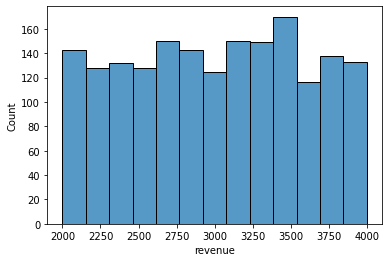

In [28]:
sns.histplot(df_test.query('revenue > 0')['revenue'])

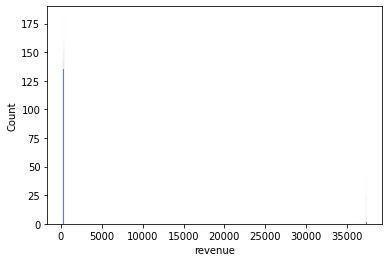

In [29]:
sns.histplot(df_control.query('revenue > 0')['revenue'])

Количество платящих пользователей в тестовой группе - 1805, в контрольной группе - 1928.
Видим что в контрольной группе персентиль 75% revenue = 361, а максимальное revenue = 37433, то есть имеется сильный выброс, который влияет на mean. Видно что такая ситуация не повторяется в тестовой группе. Все же считаю это не выбросом, просто есть пользователи, которые много купили.

Создаем датасет с количеством платящих пользователей и общим количеством пользователей по тестовым группам

In [30]:
df_rev = df.query('revenue > 0').groupby('testgroup', as_index = False).agg(paid_cnt = ('user_id', 'nunique'))
df_rev = df_rev\
.merge(df.groupby('testgroup', as_index = False).agg(users_cnt = ('user_id', 'nunique')), on = 'testgroup')

In [31]:
df_rev

,testgroup,paid_cnt,users_cnt
0,a,1928,202103
1,b,1805,202667


## Конверсия

In [32]:
df_rev['CR'] = (df_rev['paid_cnt'] / df_rev['users_cnt']) * 100
df_rev

,testgroup,paid_cnt,users_cnt,CR
0,a,1928,202103,0.953969
1,b,1805,202667,0.890624


Конверсия в контрольной группе выше чем в тестовой, для оценки значимости проведем ztest  
H0 : Конверсии в группах равны  
H1 : Конверсии в группах различаются 

In [33]:
paid_cnt = df_rev['paid_cnt'].values 
users_cnt = df_rev['users_cnt'].values 


smp.proportions_ztest(paid_cnt, users_cnt)

(2.108028495889841, 0.035028524642854865)

Отвергаем нулевую гипотезу. pvalue < 0.05 Есть статистически значимая разница в конверсии.

## ARPU

In [34]:
ARPU_test = df_test.revenue.mean()
ARPU_control = df_control.revenue.mean()
ARPU_dif = round((ARPU_test - ARPU_control) / ARPU_control * 100, 2) 
print(f'ARPU в тестовой группе - {ARPU_test}, ARPU в контрольной группе - {ARPU_control}, разница на {ARPU_dif}%')

ARPU в тестовой группе - 26.75128659327863, ARPU в контрольной группе - 25.413719736965806, разница на 5.26%


ARPU в тестовой группе выше чем в контрольной на 5.26%   

Проверим данные на нормальность

In [35]:
pg.normality(df_test.revenue, method='normaltest')

,W,pval,normal
revenue,326622.395409,0.0,False


In [36]:
pg.normality(df_control.revenue, method='normaltest')

,W,pval,normal
revenue,585152.731273,0.0,False


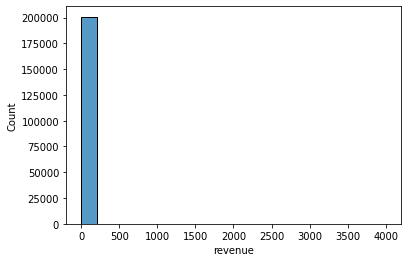

In [37]:
sns.histplot(df_test['revenue'])

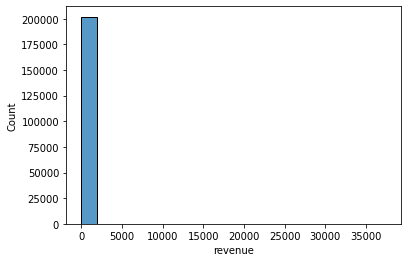

In [38]:
sns.histplot(df_control['revenue'])

Данные распределены ненормально, необходимо провести для оценки значимости критерий Манна-Уитни, но так как мы проверяем ARPU (а это средняя) значит он не годится. Следовательно будем использовать для оценки значимости ttest  
H0 = Средняя выручка c пользователя не изменилась  
H1 = Средняя выручка c пользоваеля изменилась

In [39]:
pg.ttest(x = df.query('testgroup == "a"')['revenue'], y = df.query('testgroup == "b"')['revenue'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.623488,240991.130782,two-sided,0.532965,"[-5.54, 2.87]",0.001962,0.004,0.095694


Не отвергаем нулевую гипотезу pvalue > 0.05. Изменения статистически не значимые

## ARPPU

In [40]:
ARPPU_test = df_test.query('revenue > 0').revenue.mean()
ARPPU_control = df_control.query('revenue > 0').revenue.mean()
ARPPU_dif = round((ARPPU_test - ARPPU_control) / ARPPU_control * 100, 2)
print(f'ARPPU в тестовой группе - {ARPPU_test}, ARPPU в контрольной группе - {ARPPU_control}, разница на {ARPPU_dif}%')

ARPPU в тестовой группе - 3003.6581717451522, ARPPU в контрольной группе - 2663.9984439834025, разница на 12.75%


ARPPU в тестовой группе выше чем в контрольной на 12.75%  

Проверим данные на нормальность

In [41]:
pg.normality(df_test.query('revenue > 0').revenue, method='normaltest')

,W,pval,normal
revenue,1068.860008,7.943249e-233,False


In [42]:
pg.normality(df_control.query('revenue > 0').revenue, method='normaltest')

,W,pval,normal
revenue,1394.945784,1.234161e-303,False


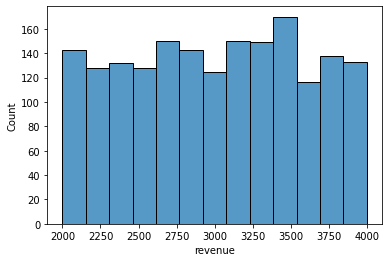

In [43]:
sns.histplot(df_test.query('revenue > 0')['revenue'])

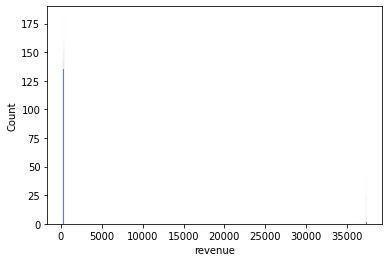

In [44]:
sns.histplot(df_control.query('revenue > 0')['revenue'])

Данные распределены ненормально, необходимо провести для оценки значимости критерий Манна-Уитни, но так как мы проверяем ARPPU (а это средняя) значит он не годится. Следовательно будем использовать для оценки значимости ttest  
H0 = Средняя выручка платящего пользователя не изменилась  
H1 = Средняя выручка платящего пользоваеля изменилась

In [45]:
pg.ttest(x = df.query('testgroup == "a" and revenue > 0')['revenue'],\
         y = df.query('testgroup == "b" and revenue > 0')['revenue'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.64463,1943.481522,two-sided,0.100208,"[-744.7, 65.38]",0.052132,0.142,0.356381


Не отвергаем нулевую гипотезу pvalue > 0.05. Изменения статистически не значимые

## Вывод: Результаты показывают что изменения в тестовой группе по результатам метрик статистически не значимы. Вероятнее всего на это влияют серьезные выбросы в контрольной группе следовательно результаты теста можно считать некорректными, стоит провести новый А/Б тест

### 3 задание  
Для оценки результатов тематического события в игре Plants & Gardens можно использовать следующие метрики:  
Метрики продукта:   
Дневная аудитория (DAU) — количество уникальных пользователей, которые зашли в приложение в течение суток.  
Месячная аудитория (MAU) — количество уникальных пользователей, которые зашли в приложение в течение месяца. По отношению средней дневной аудитории к месячной можно понимать частоту использования продукта.  
avg. DAU/MAU = stickness ratio — коэффициент того, насколько часто пользователи, в течение одного периода, "остаются" в продукте.  
Retention (удержание) - Метрика, которая показывает, как пользователи возвращаются в продукт (и часто свидетельствует, нравится ли он им).   
Churn rate (отток клиентов) - метрика обратная Retention, которая показывает, сколько клиентов потеряла компания за определённый период.  
Воронка — последовательность действий пользователей до совершения ключевого действия. Показывает, как пользователи проходят через определенную последовательность действий в продукте, на каких шагах и какая часть из них отваливается.
Среднее количество пройденных уровней 
Среднее количесиво попыток прохождения уровня - Сколько раз игроки пытались пройти отдельные уровни.
Среднее время прохождения события - Время, за которое игроки завершили событие, начиная с первого уровня и до последнего.


Денежные метрики:  
ARPPU (Average revenue per paying user) - Средний доход на платящего пользователя (то есть клиента). Состоит из того, насколько часто пользователь покупает, и насколько большой средний чек покупки.  
ARPU (Average revenue per user) - Cредний доход с привлечённого пользователя.  
LTV (lifetime value) - Пожизненная ценность клиента. Отражает, сколько в среднем приносит пользователь денег в продукт до того, как покинет его.  

При усложнении: 
Данный набор метрик будет достаточным. Возможно Churn rate увеличится. Не думаю что многие после неудачной попытки пройти уровень откатившись заходят перепроходить уровни заново. Среднее количество попыток на один уровень резко увеличится, так как игроки будут повторно проходить уровни из-за откатов.
Среднее время прохождения события - вероятно, увеличится, так как игроки будут тратить больше времени на повторение уровней. 


